# PROJECT-3. EDA + Feature Engineering

In [1]:
# Импортируем необходимые библиотеки: 
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

from sklearn import preprocessing

from sklearn.model_selection import train_test_split  

from sklearn.feature_selection import f_classif

In [4]:
from geopandas.tools import geocode
from geopy.geocoders import Nominatim

In [5]:
hotels_df = pd.read_csv('data/hotels.csv')
hotels_df.head()

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   
3                            34   9/22/2015            7.5   
4                           914    3/5/2016            8.5   

                                  hotel_name reviewer_nationality  \
0                         The May Fair Hotel      United Kingdom    
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Paris 19 Philharmonie La Villette      United Kingdom    
4                Golden Tulip Amsterdam West              Poland    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   
3          No Negative                                  0   
4         Torn sheets                                   4   

   total_number_of_reviews                                    positive_review  \
0                     1994                                 Staff were amazing   
1                     1361                                           location   
2                      406                                        No Positive   
3                      607   Friendly staff quiet comfortable room spotles...   
4                     7586   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097  
2  48.845377  2.325643  
3  48.888697  2.394540  
4  52.385601  4.847060

In [6]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

### Очистка от пропущенных значений

Для заполнения пропущенных значений в признаках координат, попробуем получить координаты отеля по его названию и городу (поиск по адресу не дал результатов), для тех отелей, для которых координаты не будут найдены, заполним усредненными координатами отелей в городе расположения.
Сначала создадим новые признаки 'country' и 'city' из признака адреса:

In [7]:
hotels_df['country'] = hotels_df['hotel_address'].apply(lambda x: x.split()[-1])
hotels_df['country'] = hotels_df['country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
display(hotels_df['country'].value_counts())

hotels_df['city'] = hotels_df['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
hotels_df['city'].value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: country, dtype: int64

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: city, dtype: int64

Признаки совпадают, но они оба будут необходимы для создания в дальнейшем новых признаков.

In [8]:
# создаем словари с усредненными по городу координатами
latitude_dict = {}
longitude_dict = {}

for city in hotels_df['city'].unique():
    latitude_dict[city] = hotels_df[hotels_df['city'] == city]['lat'].mean().round(6)
    longitude_dict[city] = hotels_df[hotels_df['city'] == city]['lng'].mean().round(6)

In [9]:
# заполняем пропущенные данные названием отеля и города
hotels_df['name_city'] = ' ' + hotels_df['hotel_name'] + ' ' + hotels_df['city']
hotels_df['lat'] = hotels_df['lat'].fillna(hotels_df['name_city'])
hotels_df['lng'] = hotels_df['lng'].fillna(hotels_df['name_city'])

hotels_df = hotels_df.drop('name_city', axis=1)

# Определяем сколько отелей не имеют координат
no_coordinates_hotels = []
for name in hotels_df['lat'].unique():
    if str(name).startswith(' '):
        no_coordinates_hotels.append(name)

print(f'Number of hotels without coordinates: {len(no_coordinates_hotels)}')

Number of hotels without coordinates: 17


In [10]:
geolocation = Nominatim(user_agent='my_request')

# создаем словари с координатами центра города (понадобятся для получения расстояния от центра города)
latitude_city_center_dict = {}
longitude_city_center_dict = {}

for city in hotels_df['city'].unique():
    latitude_city_center_dict[city] = geolocation.geocode(city).latitude
    longitude_city_center_dict[city] = geolocation.geocode(city).longitude

# наполняем словари с усредненными по городу координатами полученными с помощью Nominatim координатами отелей   
for name in no_coordinates_hotels:
    if geolocation.geocode(name.strip()) is not None:
        no_coordinates_hotels.remove(name)
        latitude_dict[name] = geolocation.geocode(name.strip()).latitude
        longitude_dict[name] = geolocation.geocode(name.strip()).longitude

        
print(f'Number of hotels without coordinates: {len(no_coordinates_hotels)}')


Number of hotels without coordinates: 11


6 из 17 отелям удалось найти координаты, остальным 11 присвоим усредненные координаты отелей по городу расположения

In [11]:
hotels_df['lat'] = hotels_df['lat'].replace(latitude_dict)
hotels_df['lng'] = hotels_df['lng'].replace(longitude_dict)

hotels_df['lat'] = hotels_df['lat'].apply(lambda x: x.split()[-1] if str(x).startswith(' ') else x)
hotels_df['lng'] = hotels_df['lng'].apply(lambda x: x.split()[-1] if str(x).startswith(' ') else x)

hotels_df['lat'] = hotels_df['lat'].replace(latitude_dict)
hotels_df['lng'] = hotels_df['lng'].replace(longitude_dict)

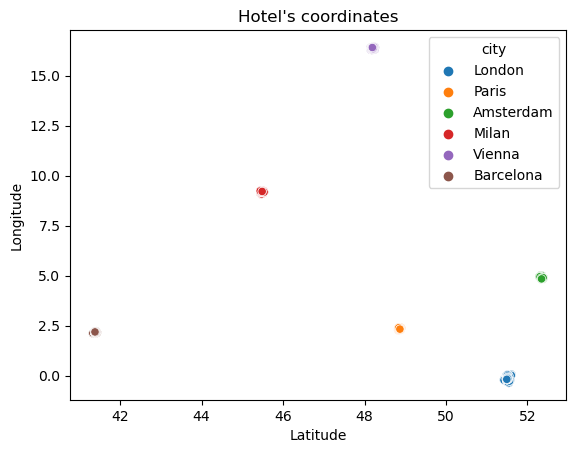

In [12]:
# Проверяем, что полученные с помощью Nominatim координаты не выглядят аномально и  находятся в близи своих городов
plt.figure()
sns.scatterplot(data=hotels_df, x='lat', y='lng', hue='city')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Hotel's coordinates")
plt.show()

In [13]:
# копируем датасет для работы с признаками
hotels = hotels_df.copy()

### Создание новых признаков

In [14]:
hotels.head()

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   
3                            34   9/22/2015            7.5   
4                           914    3/5/2016            8.5   

                                  hotel_name reviewer_nationality  \
0                         The May Fair Hotel      United Kingdom    
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Paris 19 Philharmonie La Villette      United Kingdom    
4                Golden Tulip Amsterdam West              Poland    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   
3          No Negative                                  0   
4         Torn sheets                                   4   

   total_number_of_reviews                                    positive_review  \
0                     1994                                 Staff were amazing   
1                     1361                                           location   
2                      406                                        No Positive   
3                      607   Friendly staff quiet comfortable room spotles...   
4                     7586   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day   

         lat       lng         country       city  
0  51.507894 -0.143671  United Kingdom     London  
1  51.521009 -0.123097  United Kingdom     London  
2  48.845377  2.325643          France      Paris  
3  48.888697  2.394540          France      Paris  
4  52.385601  4.847060     Netherlands  Amsterdam

Рассмотрим каждый признак отдельно для извлечения из него дополнительной информации.
Из признака 'hotel_address' уже получены признаки 'country' и 'city'.

#### additional_number_of_scoring

*additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.*

1. Предположим, что для посетителей, которые просто поставили оценку без отзыва, не было каких-либо сильных раздражающих факторов или сильно понравившихся. Поэтому создадим признак показывающий процент таких посетителей -'no_review_percentage'.
2. Также предположим, что так как для этих гостей не повлиял какой-то раздражающий фактор, из-за которого они решили написать отзыв, то их количество может указывать на условное количество посещений отеля. Создадим два признака, показывающих отели для которых предположительно много посещений и для которых мало посещений. Для опредения разграничивающих эти показатели значений рассмотрим гисторграмму.

In [15]:
hotels['no_review_percentage'] = hotels['additional_number_of_scoring']/(hotels['total_number_of_reviews'] + hotels['additional_number_of_scoring'])

<AxesSubplot: xlabel='additional_number_of_scoring', ylabel='Count'>

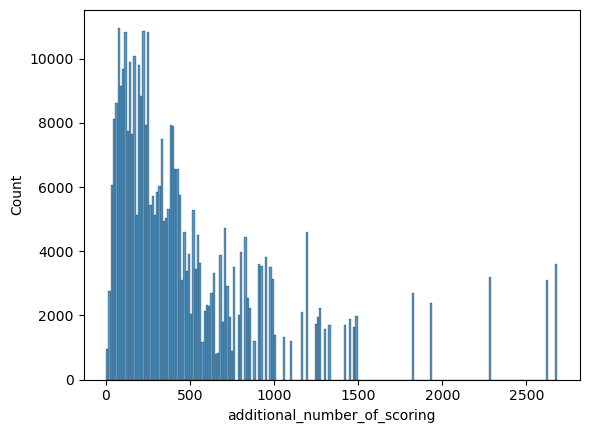

In [16]:
sns.histplot(hotels['additional_number_of_scoring'])

In [17]:
hotels['little_number_of_additional_scoring'] = hotels['additional_number_of_scoring'].apply(lambda x: True if x < 200 else False)
hotels['big_number_of_additional_scoring'] = hotels['additional_number_of_scoring'].apply(lambda x: True if x > 1000 else False)

#### lat и lng

*lat — географическая широта отеля*

*lng — географическая долгота отеля*

Так как ранее уже были получены координаты центра городов, попробуем получить расстояние от центра в условных единицах.

In [18]:
hotels['city_center'] = hotels['city'] + ',' + hotels['lat'].apply(str) + ',' + hotels['lng'].apply(str)

In [19]:
def distance_to_center(s):
    """finds distance to city center by coordinates

    Args:
        s (_str_): name of city, latitude and longitude of hotel

    Returns:
        _float_: distance to city center (conventional unit)
    """
    
    city = s.split(',')[0]
    lat = float(s.split(',')[1])
    lng = float(s.split(',')[2])
    
    distance = ((lat - latitude_city_center_dict[city])**2 + (lng - longitude_city_center_dict[city])**2) ** 1/2
    
    
    return distance
    

In [20]:
hotels['distance_city_center'] = hotels['city_center'].apply(distance_to_center)
hotels = hotels.drop('city_center', axis=1)

#### review_date

*review_date — дата, когда рецензент разместил соответствующий отзыв*

1. Предположим, что в какие-то месяцы, когда посетителей меньше отели проводят ремонт, в какие-то, когда посетителей больше, нанимают дополнительный персонал и услуги посетителям оказываются лучше. Так как все отели в выборке находятся в 6 крупных европейских городах, будем исходить из того, что все отели находятся в одинаковых климатических и социальных условиях, и тогда посещяемость по месяцам должна коррелироваться. 
Определим признак 'review_month' - месяц в котором был оставлен отзыв.
2. Также выделим год, так как с каждым годом износ отелей увеличивается.
3. Допустим, что посетители оставляют более доброжелательные отзывы в выходные, так как сами находятся в более расслабленных условиях. 

In [21]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['review_month'] = hotels['review_date'].dt.month_name()

hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_year'] = hotels['review_year'].apply(str)

hotels['is_weekend_review'] = hotels['review_date'].dt.weekday
hotels['is_weekend_review'] = hotels['is_weekend_review'].apply(lambda x: True if x > 3 else False)

#### average_score 

*average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год*

Оставим без изменения

#### hotel_name 

*hotel_name — название отеля*

Предположим, что крупные сети отелей имеют более лучший сервис, и оцениваются гостями более высоко

In [22]:
hotels['hotel_intercontinental'] = hotels['hotel_name'].apply(lambda x: True if 'intercontinental' in  x.lower().split() else False )
hotels['hotel_radisson'] = hotels['hotel_name'].apply(lambda x: True if 'radisson' in  x.lower().split() else False )
hotels['hotel_marriott'] = hotels['hotel_name'].apply(lambda x: True if 'marriott' in  x.lower().split() else False )
hotels['hotel_hilton'] = hotels['hotel_name'].apply(lambda x: True if 'hilton' in  x.lower().split() else False )

hotels['corp_hotel'] = hotels['hotel_hilton'] + hotels['hotel_marriott'] + hotels['hotel_radisson'] + hotels['hotel_intercontinental']
print(f'Part of corporation hotels: {hotels.corp_hotel.mean()}')

hotels = hotels.drop(['hotel_hilton', 'hotel_marriott', 'hotel_radisson', 'hotel_intercontinental'], axis=1)

Part of corporation hotels: 0.10915892586148504


#### reviewer_nationality

*reviewer_nationality — страна рецензента*

1. Предположим, что граждане страны, в которой находятся отели, более требовательны и их оценка отличается от оценки посетителей, не явлющихся гражданами этой страны.
2. Также предполагаем, что граждане разных стран по разному оценивают свое пребвание в отеле в силу языкового барьера, менталитета и т.д. В признаке 'reviewer_nationality' оставим только страны, где рецензентов более пяти тысяч, остальных объединим в категорию 'other'

In [23]:
hotels['reviewer_citizen'] = hotels['reviewer_nationality'] + ',' + hotels['country']
hotels['reviewer_citizen'] = hotels['reviewer_citizen'].apply(lambda x: True if x.split(',')[0].strip() == x.split(',')[1].strip() else False)

In [24]:
top_reviwer_nat = hotels['reviewer_nationality'].value_counts().head(11).index
display(hotels['reviewer_nationality'].value_counts().head(15))
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in top_reviwer_nat else 'other')

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
 France                         5543
 Israel                         4918
 Italy                          4562
 Belgium                        4529
 Turkey                         4105
Name: reviewer_nationality, dtype: int64

#### negative_review  и positive_review

*negative_review — отрицательный отзыв, который рецензент дал отелю*

*positive_review — положительный отзыв, который рецензент дал отелю*

1. В негативных и позитивных отзовах посетители также указывают, что не было негативных и позитивных факторов, повлияющих на их оценку, поэтому целесообразно добавить такие признаки "мигалки"

In [25]:
no_negative_list = ['no negative', 'nothing', 'n a', 'none', '', 'na']

hotels['no_negative'] = hotels['negative_review'].apply(lambda x: True if x.lower().strip() in no_negative_list else False)

In [26]:
no_positive_list = ['no positive', 'nothing', '', 'n a', 'none', 'na']

hotels['no_positive'] = hotels['positive_review'].apply(lambda x: True if x.lower().strip() in no_positive_list else False)

2. Также гости указывают, что **всё** было плохо или хорошо. Создадим и такие признаки "мигалки"

In [27]:
hotels['all_negative'] = hotels['negative_review'].apply(lambda x: True if x.lower().strip() == 'all' else False)
hotels['all_negative'] = hotels['all_negative'] + hotels['negative_review'].apply(lambda x: True if x.lower().strip() == 'everything' else False)

hotels['all_positive'] = hotels['positive_review'].apply(lambda x: True if x.lower().strip() == 'all' else False)
hotels['all_positive'] = hotels['all_positive'] + hotels['negative_review'].apply(lambda x: True if x.lower().strip() == 'everything' else False)

3. Посчитаем количество слов в отзовах, исключив артикли, предлоги и прочие слова, не несущие смысла, но увеличивающиие длину отзыва

In [28]:
def clean_text(text):
    """returns list of words in text without prepositions and speсial words

    Args:
        text (str): text

    Returns:
        (list): list of words
    """
    
    prep_list = [
        'a', 'the', 'no', 'not', 'do', 'dont', 'does', 'doesnt', 'did', 'didnt', 
        'at', 'about', 'among', 'before', 'below', 'between', 'by', 'for', 'from', 
        'in', 'into', 'of', 'on', 'off', 'out', 'over', 'since', 'untill', 'till',
        'through', 'to', 'under', 'because', 'with', 'instead', 'above', 'against',
        'along', 'across', 'after', 'ago', 'around', 'behind', 'beside', 'and', 
        'but', 't', 'as', 'so', 'my', 'our', 'to', 'or', 'don', 'didn', 'an', 'too',
        'this', 'would', 'if', 's', 'been', 'up', 'your', 'will', 'although', 'its',
        'also', 'which', 'within', 'due', 'until', 'near', 'nearby', 'is', 'isn', 
        'are', 'aren', 'was', 'wasn', 'were', 'weren', 'this', 'that', 'there',
        'should', 'wouldn', 'per', 'while', 'away', 'down', 'here', 'has', 'have', 
        'hasn', 'haven', 'having', 'when', 'he', 'she', 'it', 'they', 'i', 'who',
        'we', 'you', 'your', 'could'
        ]
    
    text = ' ' + text.lower().strip() + ' '
    
    for word in prep_list:
        word = ' ' + word + ' ' # add ' ' to find the whole word and except that it will be part of word
        text = text.replace(word, ' ')
    
      
    return text.split()

In [29]:
hotels['words_in_negative_review'] = hotels['negative_review'].apply(clean_text)
hotels['num_words_in_negative_review'] = hotels['words_in_negative_review'].apply(len)
# вычтем те отзывы, которые не имели негатива - признак 'no_negative', т.к. после очистки они будут иметь только по одному слову вычтем весь признак
# добавим только те отзывы, где был пробел, т.к. они вычтутся с признаком 'no_negative', аналогично для позитивных отзывов
hotels['num_words_in_negative_review'] = hotels['num_words_in_negative_review'] - hotels['no_negative']
hotels['num_words_in_negative_review'] = hotels['num_words_in_negative_review'] + hotels['negative_review'].apply(lambda x: 1 if x == ' ' else 0)

hotels['words_in_positive_review'] = hotels['positive_review'].apply(clean_text)
hotels['num_words_in_positive_review'] = hotels['words_in_positive_review'].apply(len)
hotels['num_words_in_positive_review'] = hotels['num_words_in_positive_review'] - hotels['no_positive']
hotels['num_words_in_positive_review'] = hotels['num_words_in_positive_review'] + hotels['positive_review'].apply(lambda x: 1 if x == ' ' else 0)

4. Посчитаем количество негативных/позитивных слов в отзыве

In [30]:
def count_words_from_list(text, list):
    """counts number of words from list in text

    Args:
        text (str): text

    Returns:
        int: number of words
    """
    
    count = 0
    text = ' ' + text.lower().strip() + ' '
    
    for word in list:
        word = ' ' + word + ' '
        count += text.count(word)
    
    
    return count

In [31]:
negative_words_list = [
        'bad', 'worse', 'disappointed', 'dislike', 'unpleasant', 'couldn t', 'overheat', 'cold', 'worn',
        'no', 'not', 'wasn t', 'don t', 'didn t', 'doesn t', 'less', 'tiny', 'small', 'little', 'rude',
        'old', 'low', 'dirt', 'poor', 'expensive', 'waiting', 'stinky', 'smelly', 'unfriendly', 'need', 
        'impudent', 'difficult', 'complicated', 'damage', 'empty', 'boring', 'broken', 'tired', 'slow',
        'weak', 'uncomfortable', 'unpalatable', 'loud', 'noisy', 'busy', 'problem', 'shabby', 'ugly', 
        'homely', 'plain', 'trash', 'wretch', 'standard', 'sleazy', 'second class', 'one star', 'modest',
        'average', 'economical', 'inferior', 'lousy', 'torn', 'cannot', 'badly', 'noise', 'uncomfy', 
        'cannot', 'hot', 'cold', 'late', 'limited', 'disappointing', 'wouldn t', 'wrong', 'minor', 'pricey'
    ]

positive_words_list = [
        'good', 'better', 'great', 'grand', 'like', 'love', 'fashion', 'more', 'big', 'large', 
        'new', 'high', 'clean', 'beautiful', 'cheap', 'gorgeos', 'friendly', 'easy', 'splendid', 'lux', 
        'smart', 'safe', 'elegant', 'respectable', 'fun', 'full', 'vast', 'strong', 'comfortable', 
        'palatable', 'nice', 'pleasant', 'no problrm', 'tasty', 'appetizing',  'exclusive', 'decent', 
        'roomy', 'handsome', 'smile', 'quiet', 'restful', 'pretty', 'relax', 'cool', 'happy', 'merry', 
        'chill', 'helpful', 'healthy', 'comfy', 'quick', 'courteous', 'close', 'fabulous', 'spacious', 
        'simple', 'convenient', 'fine', 'first class', 'lovely', 'well', 'modern', 'recommend', 'welcoming',  
        'professional', 'top', 'extra', 'delicious'       
    ]


In [32]:
count_negative_words = lambda x: count_words_from_list(x, negative_words_list)
count_positive_words = lambda x: count_words_from_list(x, positive_words_list)

hotels['num_negative_words'] = hotels['negative_review'].apply(count_negative_words)
hotels['num_positive_words'] = hotels['positive_review'].apply(count_positive_words)

5. Поcчитаем количество слов в отзовах, в которых употреблялись крайне негативные (худший, отвратительно и т.д.) и крайне позитивные (великолепно, идеально). Идея состоит в том, что более эмоциональные отзыва сильнее влияют на итоговую оценку

In [33]:
very_negative_list = [
        'everything', 'all', 'worst', 'outrageous', 'disgust', 'never', 'danger', 
        'miserable', 'horrible', 'terrible', 'rotten', 'revulsion', 'dreadful',
        'awful', 'very', 'extremely', 'definitely'     
    ]

very_positive_list = [
        'everything', 'all', 'best', 'excellent', 'outstanding', 'happiest', 
        'amazing','wonderful', 'brilliant', 'perfect', 'fantastic', 'magnificent',
        'very', 'superb', 'extremely', 'definitely', 'super', 'most' 
    ]

In [34]:
count_negative_words = lambda x: count_words_from_list(x, very_negative_list)
count_positive_words = lambda x: count_words_from_list(x, very_positive_list)

hotels['num_very_negative_words'] = hotels['negative_review'].apply(count_negative_words)
hotels['num_very_positive_words'] = hotels['positive_review'].apply(count_positive_words)

6. Также предположим, что негативный/позитивный опыт, полученный от разных услуг отеля, посетители оценивают по разному. Выделим 4 основные сферы услуг, оказывемые отелями: проживание, питание, досуг, бизнес услуги (конференц зал, интернет, расположение и т.д.)

In [35]:
def hotel_elements(text):
    """tags if text is about one of elements of hotel (accommodation, meal, leisure, business) 

    Args:
        text (str): text

    Returns:
        list: list of 4 bool variables
    """
    
    result = [False, False, False, False]
    
    accommodation_list = [
        'accommodation', 'room', 'rooms', 'suite', 'suites', 'bedroom', 'bath', 'toilet',
        'bed', 'beds', 'furniture', 'chair', 'mirror', 'wardrobe', 'tv ', 'conditioning', 
        'view', 'balcon', 'vault', 'bedding', 'linen', 'towel', 'minibar', 'fridge', 
        'shower', 'slippers', 'lobby', 'elevator', 'staff', 'check-in', 'kettle',  
        'leaving', 'reception', 'floor', 'parking', 'service', 'door', 'window',
        'pillows', 'luggage'
    ]
    meal_list = [
        'meal', 'breakfast', 'lunch', 'dinner', 'branch', 'supper', 'restaurant', 
        'bar', 'buffet', 'eating', 'food', 'catering', 'room service', 'cafe', 
        'coffee', 'drink', 'dishes', 'dish',  'plate', 'waiter', 'waitress'
        'restaurants', 'bars', 'tea', 'water', 'atmosphere'  
    ]
    leisure_list = [
        'leisure', 'garden', 'entertainment', 'animation', 'relax', 'recreation',
        'spa', 'pool', 'sport', 'attractions', 'park ', 'music', 'area', 'decor',
        'shopping'
    ]
    business_list = [
        'business', 'internet', 'wifi', 'conference', 'transfer', 'location',
        'arrival', 'metro', 'centre', 'underground', 'tram', 'bus', 'taxi'
        ]
    
    for word in accommodation_list:
        if word in text.lower().split():
            result[0] = True
    
    for word in meal_list:
        if word in text.lower().split():
            result[1] = True
            
    for word in leisure_list:
        if word in text.lower().split():
            result[2] = True
            
    for word in business_list:
        if word in text.lower().split():
            result[3] = True
    
    
    return result

In [36]:
hotels['negative_elements'] = hotels['negative_review'].apply(hotel_elements)

hotels['negative_accommodation'] = hotels['negative_elements'].apply(lambda x: x[0])
hotels['negative_meal'] = hotels['negative_elements'].apply(lambda x: x[1])
hotels['negative_leisure'] = hotels['negative_elements'].apply(lambda x: x[2])
hotels['negative_business'] = hotels['negative_elements'].apply(lambda x: x[3])

hotels = hotels.drop('negative_elements', axis=1)

In [37]:
hotels['positive_elements'] = hotels['positive_review'].apply(hotel_elements)

hotels['positive_accommodation'] = hotels['positive_elements'].apply(lambda x: x[0])
hotels['positive_meal'] = hotels['positive_elements'].apply(lambda x: x[1])
hotels['positive_leisure'] = hotels['positive_elements'].apply(lambda x: x[2])
hotels['positive_business'] = hotels['positive_elements'].apply(lambda x: x[3])

hotels = hotels.drop('positive_elements', axis=1)

7. Предположим, что определенные слова, которые наиболее часто встречаются в отзывах, имеют разный эмоционалтный окрас и вес в определении итоговой оценки (например плохой завтрак больше влияет на снижение оценки, чем проблемы с номером или наоборот), выделим по 7 таких слов в позитивном и в негативных отзывах

In [38]:
neg_word_dict = {}

for word_list in hotels['words_in_negative_review']:
    
    for word in word_list:
        word = word.strip().lower()
        if word in neg_word_dict.keys():
            neg_word_dict[word] += 1
        else:
            neg_word_dict[word] = 1


neg_word_list = sorted(neg_word_dict.items(), key=lambda x: x[1], reverse=True)
print(neg_word_list[0:25])

[('room', 132025), ('negative', 97092), ('very', 60354), ('hotel', 55916), ('had', 45194), ('breakfast', 43528), ('small', 37372), ('be', 33943), ('staff', 29670), ('nothing', 29016), ('rooms', 26166), ('bed', 22291), ('all', 21765), ('one', 21052), ('only', 21034), ('bit', 20583), ('bathroom', 20004), ('night', 18003), ('like', 16800), ('little', 16781), ('shower', 15970), ('good', 15577), ('us', 15304), ('more', 15239), ('get', 14713)]


In [39]:
pos_word_dict = {}

for word_list in hotels['words_in_positive_review']:
    
    for word in word_list:
        word = word.strip().lower()
        if word in pos_word_dict.keys():
            pos_word_dict[word] += 1
        else:
            pos_word_dict[word] = 1


pos_word_list = sorted(pos_word_dict.items(), key=lambda x: x[1], reverse=True)
print(pos_word_list[0:15])

[('staff', 145874), ('location', 144568), ('very', 144568), ('room', 105728), ('hotel', 94000), ('good', 84480), ('great', 79160), ('friendly', 63870), ('breakfast', 63307), ('helpful', 57201), ('nice', 52027), ('clean', 50250), ('excellent', 46761), ('comfortable', 44843), ('bed', 37464)]


In [40]:
neg_words_list = ['room', 'breakfast', 'small', 'staff', 'very', 'bed', 'bathroom']
pos_words_list = ['staff', 'location', 'very', 'room', 'good', 'breakfast', 'friendly']

for word in neg_words_list:
    hotels[f'word_{word}_in _neg_review'] = hotels['words_in_negative_review'].apply(lambda x: True if word in x else False)

for word in pos_words_list:
    hotels[f'word_{word}_in _pos_review'] = hotels['words_in_positive_review'].apply(lambda x: True if word in x else False)

#### review_total_negative_word_counts  и review_total_positive_word_counts

*review_total_negative_word_counts — общее количество слов в отрицательном отзыв*

*review_total_positive_word_counts — общее количество слов в положительном отзыве*

Оставим без изменений

#### reviewer_score 

*reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта*

Целевая переменная

#### total_number_of_reviews  и total_number_of_reviews_reviewer_has_given

*total_number_of_reviews — общее количество действительных отзывов об отеле*

*total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом*

Оставим без изменений

#### tags

*tags — теги, которые рецензент дал отелю*

1. Предположим, что количество тегов влияет на оценку рецензента
2. Выделим самые распространенные теги и создадим признаки "мигалки", показывающий дал ли этот тег отелю рецензент

In [41]:
hotels['len_tags'] = hotels['tags'].apply(len)

In [46]:
tags_dict = {}

for tags_list in hotels['tags']:
    tags_list = tags_list.split("'")
    tags_list.remove('[')
    tags_list.remove(']')
    tags_list = list(filter(lambda x: x != ', ', tags_list))
    
    for tag in tags_list:
        tag = tag.strip()
        if tag in tags_dict.keys():
            tags_dict[tag] += 1
        else:
            tags_dict[tag] = 1


tags_dict = dict(sorted(tags_dict.items(), key=lambda x: x[1], reverse=True))
print(list(tags_dict.keys()))

['Leisure trip', 'Submitted from a mobile device', 'Couple', 'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip', 'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room', 'Standard Double Room', 'Superior Double Room', 'Family with older children', 'Deluxe Double Room', 'Double or Twin Room', 'Stayed 5 nights', 'Standard Double or Twin Room', 'Classic Double Room', 'Superior Double or Twin Room', '2 rooms', 'Stayed 6 nights', 'Standard Twin Room', 'Single Room', 'Twin Room', 'Stayed 7 nights', 'Executive Double Room', 'Classic Double or Twin Room', 'Superior Twin Room', 'Club Double Room', 'Deluxe Double or Twin Room', 'Queen Room', 'Deluxe King Room', 'Superior Queen Room', 'Standard Single Room', 'Junior Suite', 'Triple Room', 'Classic Room', 'Superior Room', 'Superior King Room', 'Standard Room', 'Deluxe Room', 'Double Guest Room', 'Standard Queen Room', 'Deluxe Single Room', 'Small Double Room', 'Queen Guest Room', 'Deluxe Twin R

In [43]:
for tag in list(tags_dict.keys())[0:12]:
    hotels[f'tag_{tag}'] = hotels['tags'].apply(lambda x: True if tag in x else False)

#### days_since_review 

*days_since_review — количество дней между датой проверки и датой очистки*

Переведем данный признак в числовой


In [47]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

Удалим тектовые признаки и признак города, который дублирует признак страны

In [48]:
drop_list = [
    'hotel_address', 'hotel_name', 'negative_review', 'positive_review', 'city', 
    'tags', 'review_date', 'words_in_positive_review', 'words_in_negative_review'
]

hotels = hotels.drop(drop_list, axis=1)

In [49]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 66 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   reviewer_nationality                        386803 non-null  object 
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   review_total_positive_word_counts           386803 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 7   reviewer_score                              386803 non-null  float64
 8   days_since_review                           386803 non-null  int64  
 9   lat                                         386803 non-null  float64
 

In [50]:
# кодируем категориальные признаки
hotels = pd.get_dummies(hotels, columns=hotels.dtypes[hotels.dtypes == 'object'].index)

In [51]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [52]:
bool_cols = list(X.dtypes[(X.dtypes == 'bool') | (X.dtypes == 'uint8')].index)
num_cols = list(X.dtypes[(X.dtypes == 'int64') | (X.dtypes == 'float64')].index)

<AxesSubplot: >

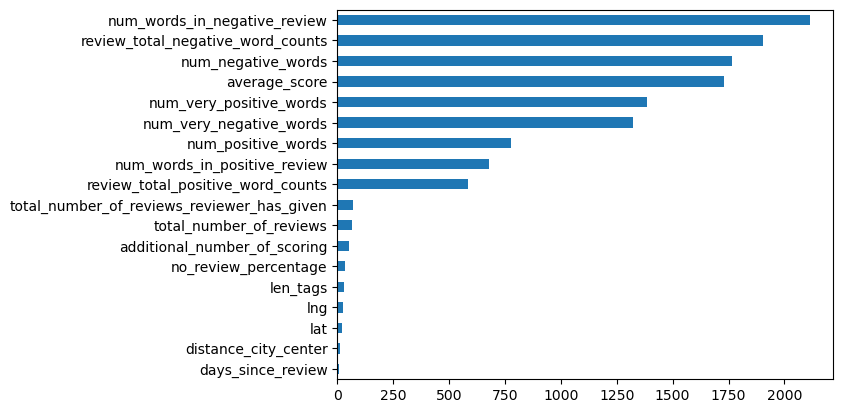

In [53]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot: >

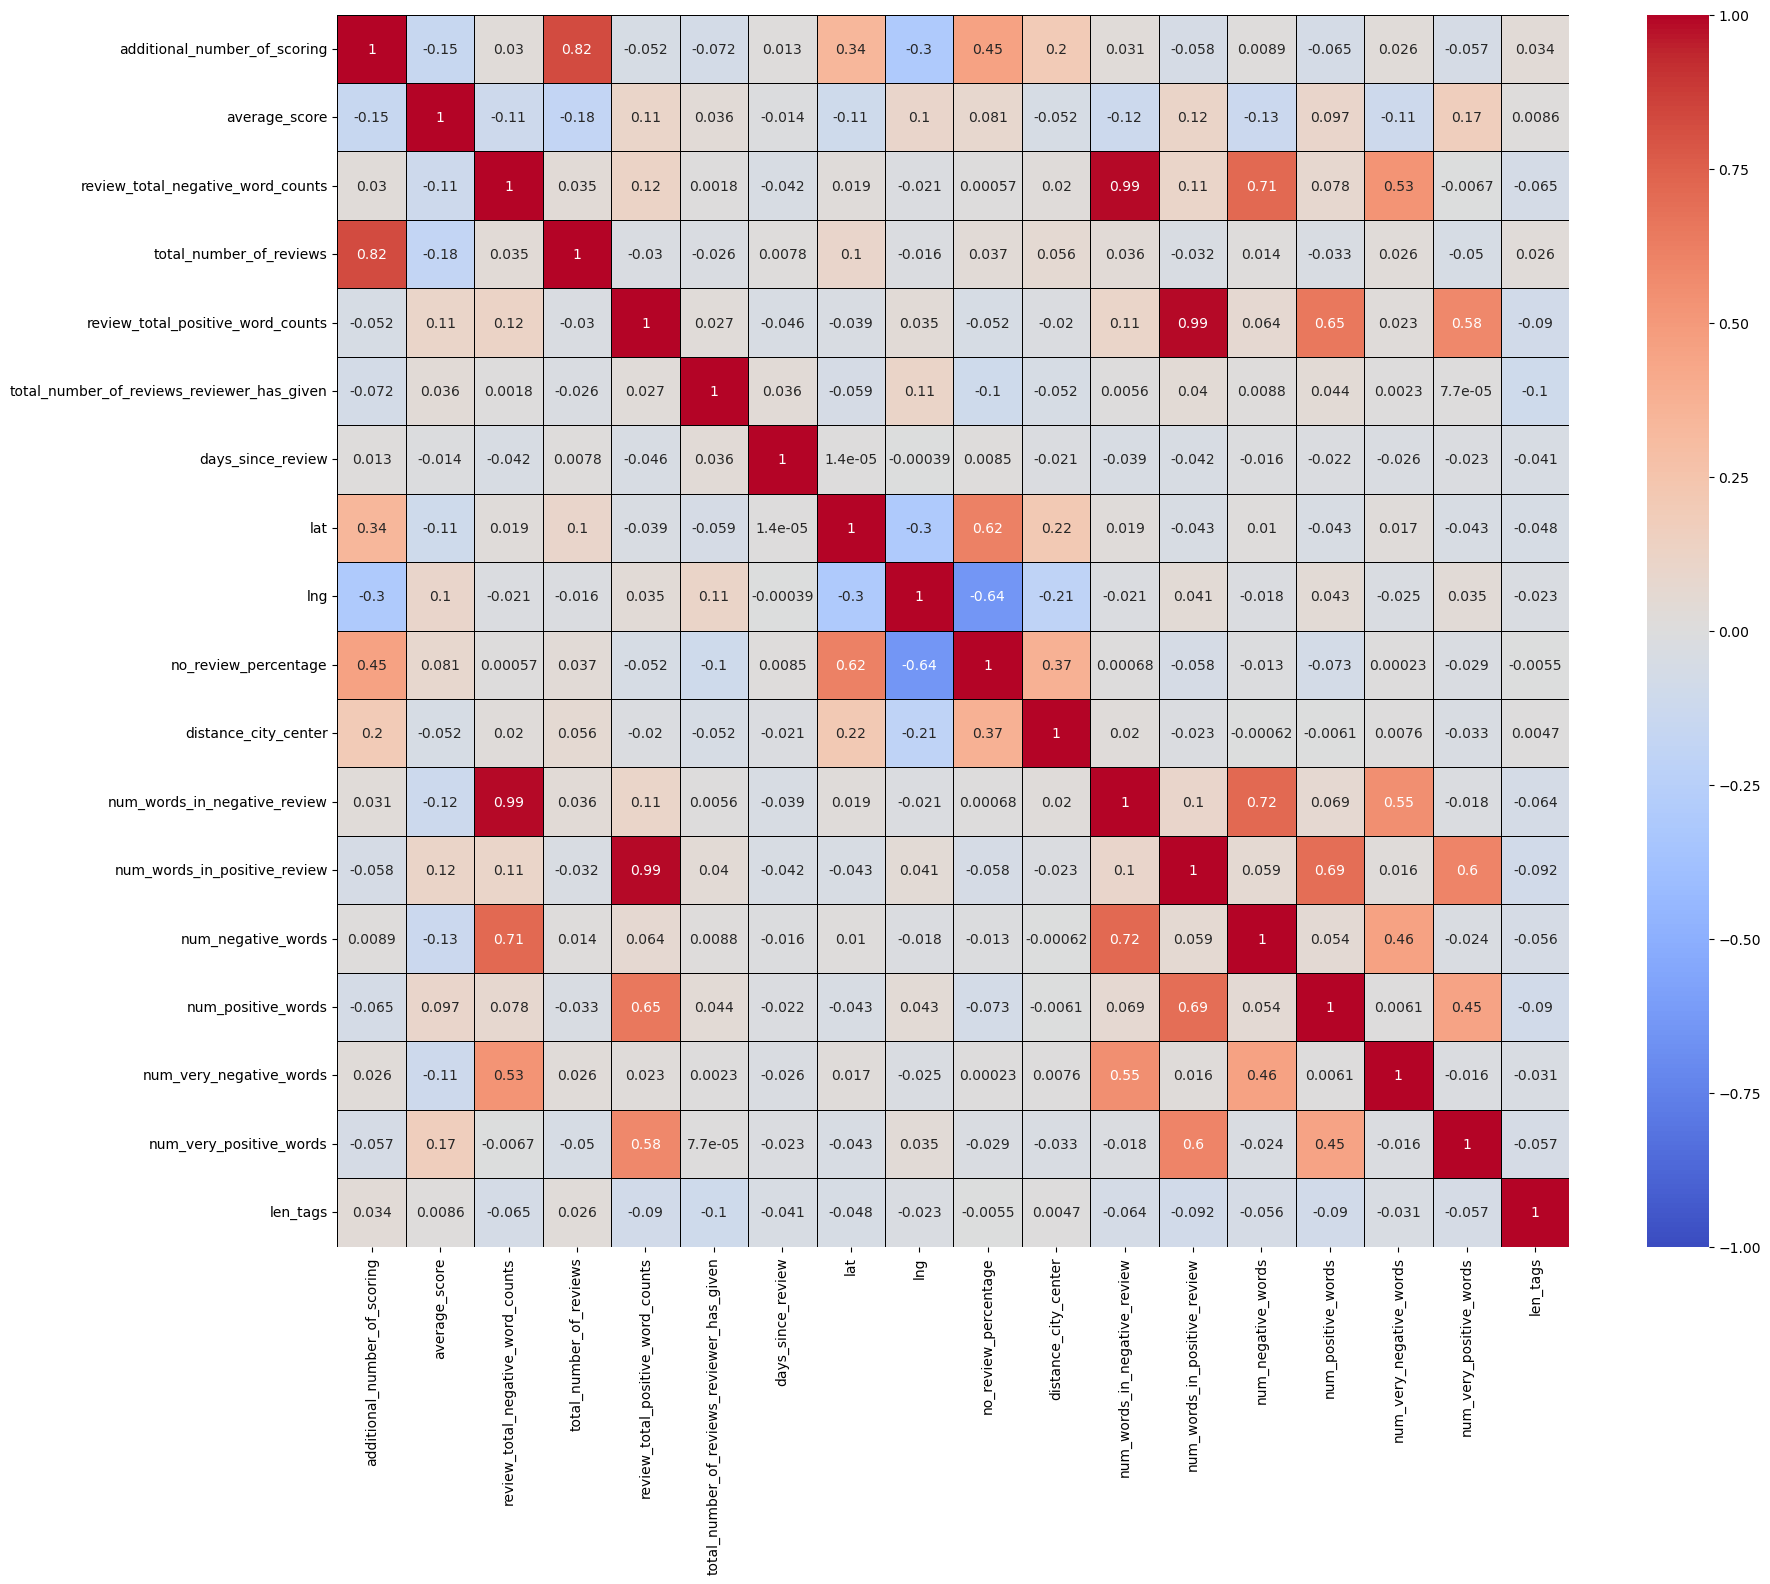

In [54]:
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(X[num_cols].corr(), linewidths=0.5, linecolor='black', cmap='coolwarm', annot=True, vmin=-1, vmax=1, center= 0, square=True, ax=ax)

In [55]:
#X = X.drop(['review_total_negative_word_counts', 'review_total_positive_word_counts'], axis=1)
X = X.drop(['lat', 'lng'], axis=1)
X = X.drop(['additional_number_of_scoring'], axis=1)


c:\Users\admin\anaconda3\envs\MyEnv\Lib\site-packages\scipy\stats\_stats_py.py:5218: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
c:\Users\admin\anaconda3\envs\MyEnv\Lib\site-packages\scipy\stats\_stats_py.py:5219: RuntimeWarning: invalid value encountered in sqrt
  z = con_minus_dis / np.sqrt(var)


<AxesSubplot: >

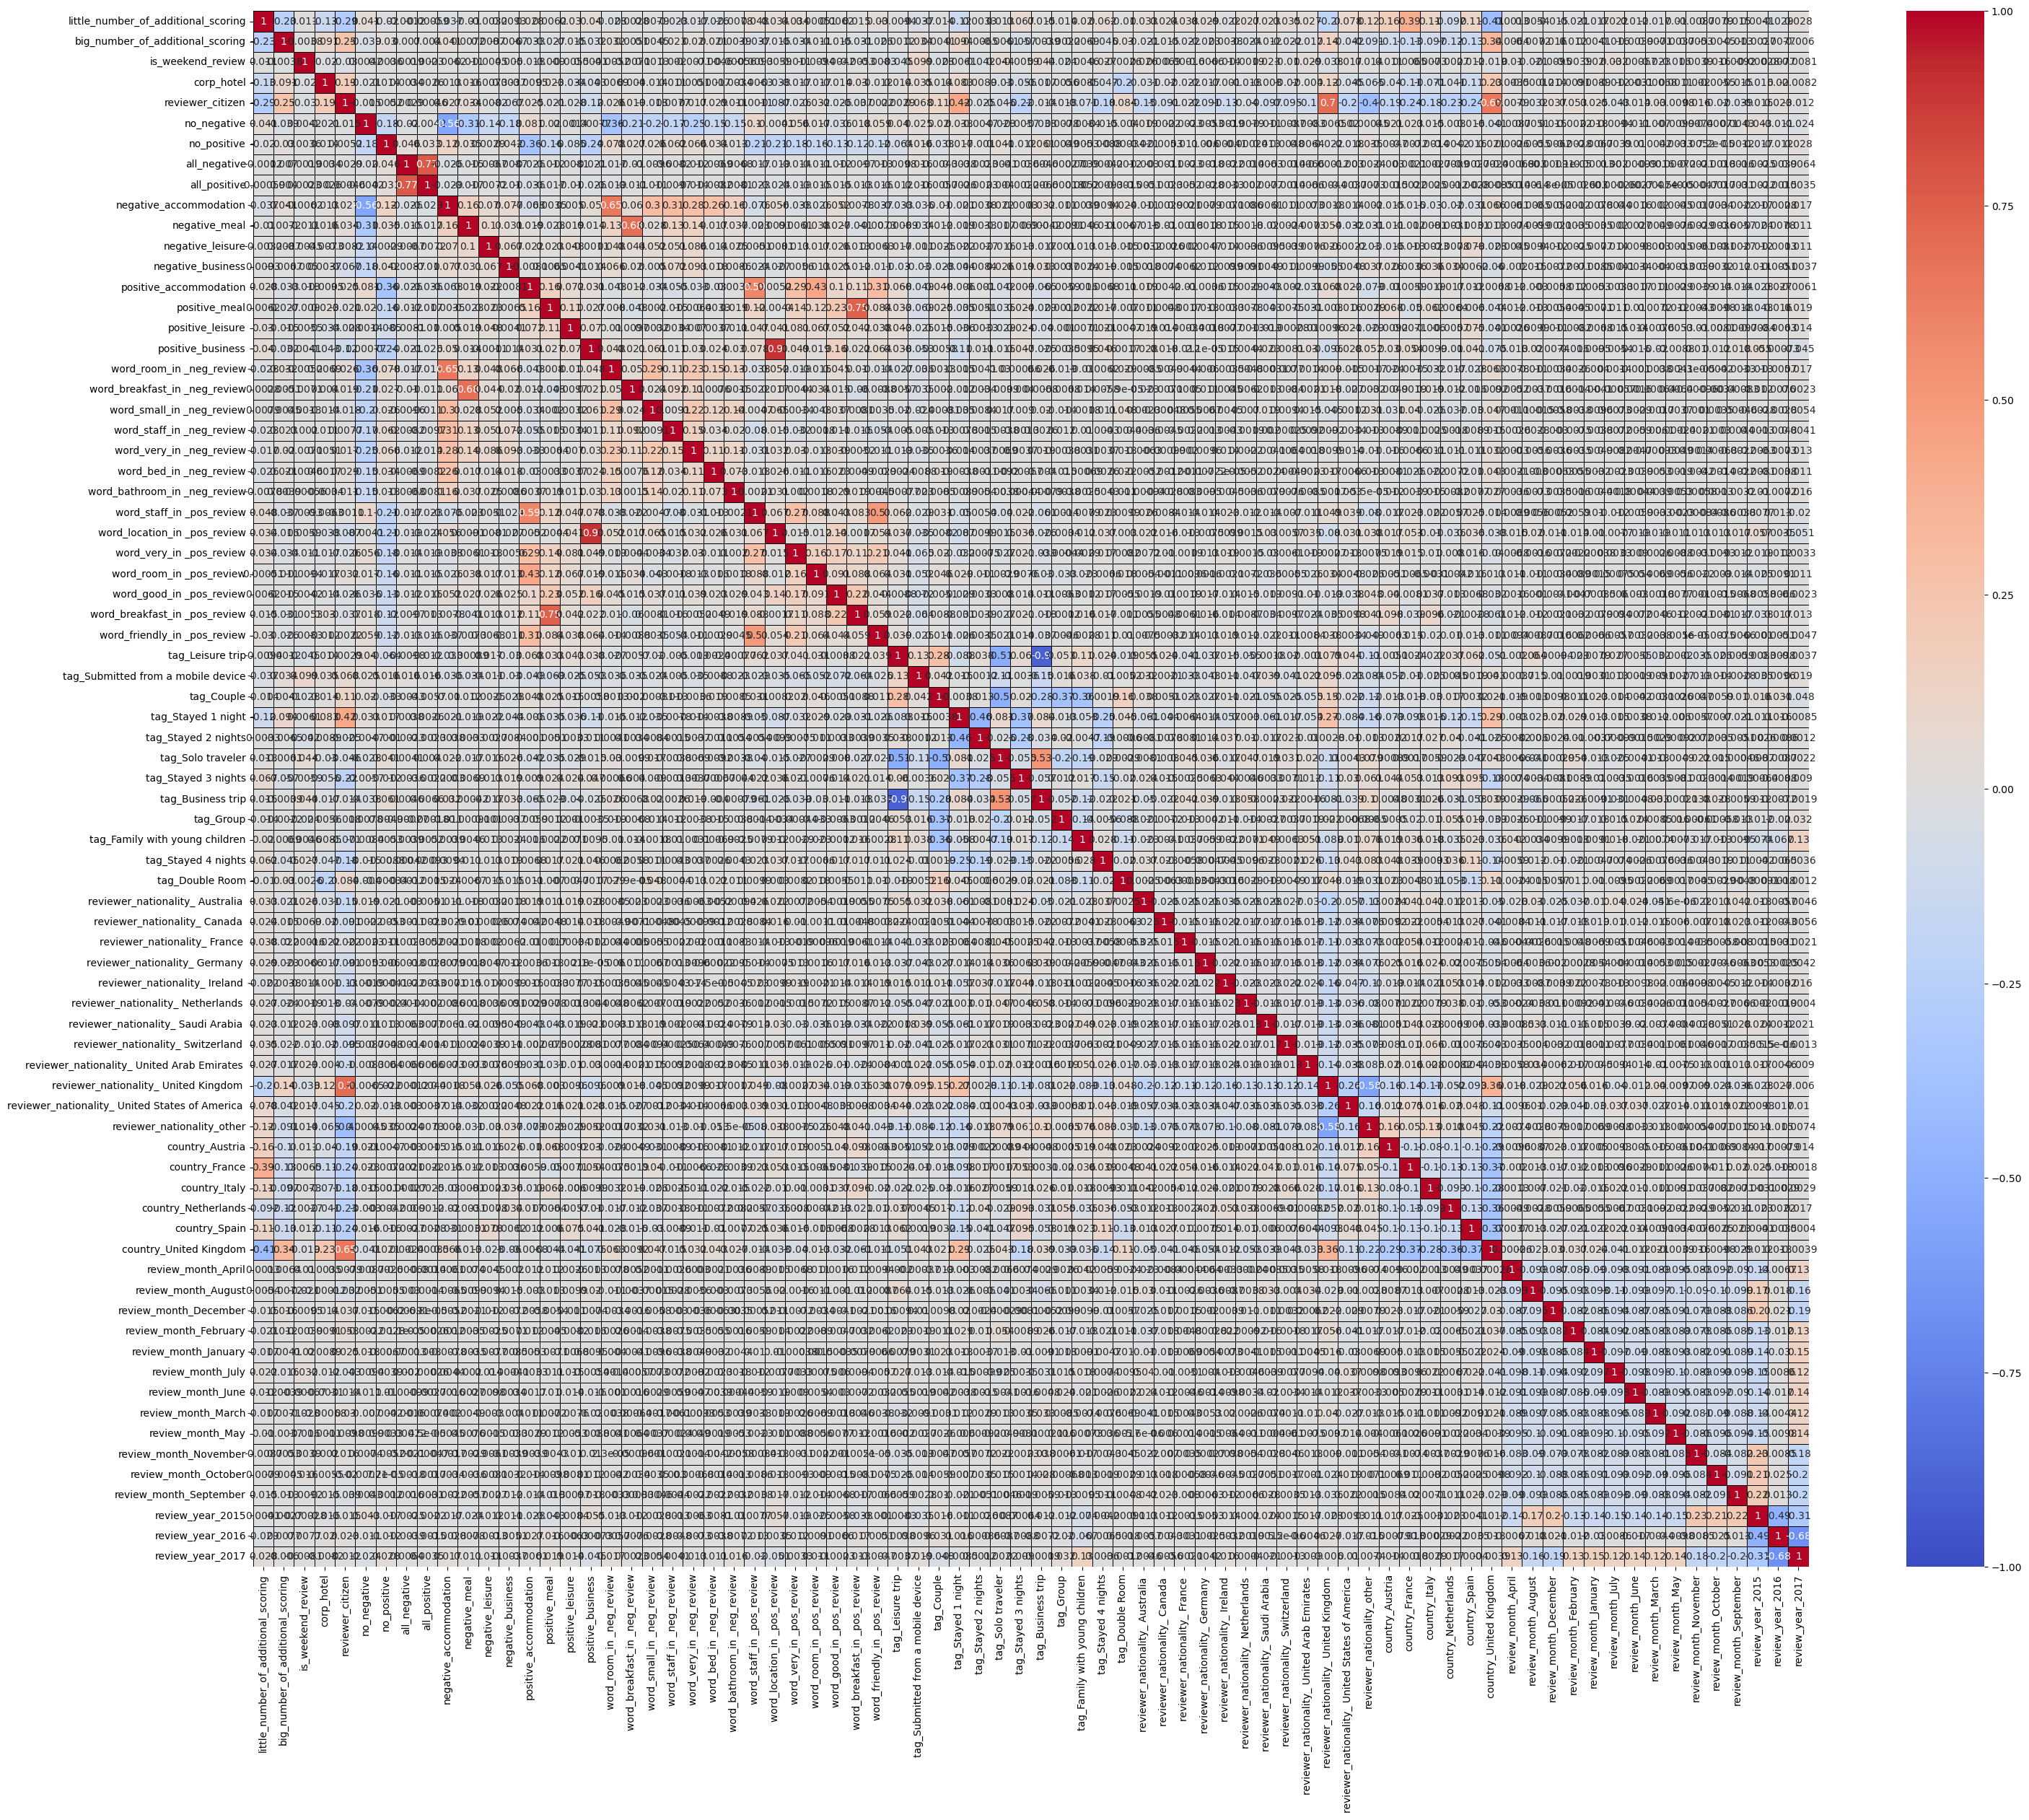

In [56]:
fig, ax = plt.subplots(figsize=(35,28))
sns.heatmap(X[bool_cols].corr('kendall'), linewidths=0.5, linecolor='black', cmap='coolwarm', annot=True, vmin=-1, vmax=1, center= 0, square=True, ax=ax)

In [57]:
X = X.drop(['tag_Leisure trip', 'reviewer_citizen', 'positive_business'], axis=1)

In [58]:
# нормализация данных
col_names = X.columns

mm_scaler = preprocessing.MinMaxScaler()

hotels_mm = mm_scaler.fit_transform(X)
X = pd.DataFrame(hotels_mm, columns=col_names)

In [59]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [60]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [61]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12154802159315316
